In [2]:
options (warn = -1)
library(openxlsx)
library(tidyverse)
library(reshape)
library(mgsub) # mapping

library(ggplot2)
library(ggpubr)
library(RColorBrewer)
library(corrplot)
library(corrr)
library(Rtsne)
library(ggrepel)#text
library(psych)#corr.test

In [3]:
# Organize relationship score
regions = c(
    # English
    'USA','UK','Australia','South Africa',
    # Germany
    'Germany',
    # Japanese
    'Japan',
    # Hebrew
    'Israel',
    # Chinese
    'CHN','HK(region)',

    # French
    'France',
    # Spanish
    'Spain','Mexico','Chile',
    # Portuguese
    'Portugal','Brazil',
    # Russian
    'Russia',
    # Arabic
    'Egypt','Qatar',
    'India')

Activity intensity-raw data of "neighbors"  
Formality-averaged global results of "neighbor of neighbors"

# Modern level  
average the scaled three indexs

In [4]:
modern_scaled = read.csv('../../../output_graph/modern_scaled_three_index.csv',row.names=1)
modern_scaled = modern_scaled %>% mutate(avg=apply(., 1, mean)) 
modern_scaled %>% arrange(avg)

,Edu_2018,Urban_2020,Wealth_2015,avg
,<dbl>,<dbl>,<dbl>,<dbl>
India,-1.42145445,-2.57023259,-1.305654245,-1.7657804
"Egypt, Arab Rep.",-0.97156411,-2.09952683,-1.122208603,-1.3977665
South Africa,-1.59812620,-0.62750047,-1.077027031,-1.1008846
China,-0.48619948,-0.98252176,-1.112046342,-0.8602559
Mexico,-0.86296002,0.17390349,-0.812989360,-0.5006820
Portugal,0.13850531,-0.69004556,-0.229886034,-0.2604754
Brazil,-0.37614086,0.55384697,-0.873162096,-0.2318187
Qatar,-1.84422258,1.28246138,-0.097359039,-0.2197067
Russian Federation,0.92348586,-0.18417317,-0.841913579,-0.0342003


# Neighbor in raw data

## Import data

In [6]:
neighbor_raw_df = data.frame(matrix(ncol=3,nrow=19))
colnames(neighbor_raw_df) = c('Activeness_raw','Activity_raw','Formality_raw')
rownames(neighbor_raw_df) = regions

file_path = '../../../DataCleanPCA/output_data/cleaning_results/'
raw_data_list = list()
for (region in dir(file_path)[-which(dir(file_path)=="ReadMe.txt")]){
    file = paste(file_path,region,sep='')
    file = paste(paste(file,'/',sep=''),region,sep='')
    file = paste(file,'_dim_rel_scaled.csv',sep='')
    raw_df = read.csv(file,row.names=1,check.names=FALSE)
    region = gsub('HK','HK(region)',region) 
    region = gsub('South_africa','South Africa',region)
    
    neighbor_raw_df[region,'Activeness_raw'] = raw_df['Between neighbors','Activeness']
    neighbor_raw_df[region,'Activity_raw'] = raw_df['Between neighbors','Activity Intensity']
    neighbor_raw_df[region,'Formality_raw'] = raw_df['Between neighbors','Formality and Regulation']
    raw_data_list[[region]] = raw_df}

In [7]:
dir(file_path)

[1] "Australia"    "Brazil"       "Chile"        "CHN"          "Egypt"       
 [6] "France"       "Germany"      "HK"           "India"        "Israel"      
[11] "Japan"        "Mexico"       "Portugal"     "Qatar"        "ReadMe.txt"  
[16] "Russia"       "South_africa" "Spain"        "UK"           "USA"

In [12]:
neighbor_raw_df %>% arrange(Activity_raw)

,Activeness_raw,Activity_raw,Formality_raw
,<dbl>,<dbl>,<dbl>
Australia,-1.18610691,-1.2418053,-0.99037234
UK,-0.44828184,-1.1165794,0.34311716
HK(region),-0.12813774,-1.0784950,-1.32133041
France,-1.70841471,-1.0181032,0.18247106
Germany,-0.82431395,-0.9310547,-0.42052587
Mexico,-1.25684435,-0.9136636,-0.15928546
Japan,-0.66224482,-0.8726408,-0.12543689
Russia,-0.43292946,-0.7769783,-0.29398612
Portugal,-0.17175720,-0.6601946,-0.23682567


## Correlation

In [9]:
regions_order = rownames(neighbor_raw_df)
fix_region = function(df){
    regions = rownames(df)
    regions = str_replace(regions,'United States','USA')
    regions = str_replace(regions,'United Kingdom','UK')
    regions = str_replace(regions,'China','CHN')
    regions = str_replace(regions,'South_africa','South Africa')
    regions = str_replace(regions,'Spain','Spanish')
    regions = str_replace(regions,'HK','HK(region)')
    regions = gsub('Hong Kong SAR, CHN','HK(region)',regions,fixed=TRUE)
    regions = str_replace(regions,'Hong Kong','HK(region)')
    regions = str_replace(regions,'Spanish','Spain')
    regions = str_replace(regions,'Russian Federation','Russia')
    regions = str_replace(regions,'Russian','Russia')
    regions = str_replace(regions,'Egypt, Arab Rep.','Egypt')
        
    rownames(df) = regions
    df = t(df)
    df = data.frame(df[,regions_order])
    colnames(df) = c('avg')
    return(df)
}

modern_level = modern_scaled['avg']
modern_level = fix_region(modern_level)
Raw_modern = cbind(neighbor_raw_df,modern_level)
cor(Raw_modern,method='spearman')

,Activeness_raw,Activity_raw,Formality_raw,avg
Activeness_raw,1.0000000,0.33333333,-0.28421053,-0.2526316
Activity_raw,0.3333333,1.00000000,-0.08245614,-0.5561404
Formality_raw,-0.2842105,-0.08245614,1.00000000,0.1368421
avg,-0.2526316,-0.55614035,0.13684211,1.0000000


In [10]:
cor.test(x=Raw_modern$'avg',y=Raw_modern$'Activity_raw',method='spearman')
cor.test(x=Raw_modern$'avg',y=Raw_modern$'Activeness_raw',method='spearman')
cor.test(x=Raw_modern$'avg',y=Raw_modern$'Formality_raw',method='spearman')


	Spearman's rank correlation rho

data:  Raw_modern$avg and Raw_modern$Activity_raw
S = 1774, p-value = 0.01487
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.5561404 



	Spearman's rank correlation rho

data:  Raw_modern$avg and Raw_modern$Activeness_raw
S = 1428, p-value = 0.2954
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2526316 



	Spearman's rank correlation rho

data:  Raw_modern$avg and Raw_modern$Formality_raw
S = 984, p-value = 0.5752
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1368421 


In [11]:
Plot_corr = function(data,ylabel){
    regions_fix = rownames(data)
    regions_fix = gsub('HK(region)','Hongkong SAR',regions_fix,fixed=TRUE)
    regions_fix = gsub('CHN','China',regions_fix,fixed=TRUE)
    regions_fix = gsub('USA','United States',regions_fix,fixed=TRUE)
    regions_fix = gsub('UK','United Kingdom',regions_fix,fixed=TRUE)
    rownames(data) = regions_fix
    
    ylabel = enquo(ylabel)
    ggplot(data,aes(x=avg,y=!!ylabel,label=rownames(data)))+
    geom_point(size=2)+
    geom_text_repel(size=8)+

    geom_smooth(method = 'lm', size=3,formula = y ~ x) +
    geom_hline(aes(yintercept = 0),linetype="dashed",size=1.5)+
    geom_vline(aes(xintercept = 0),linetype="dashed",size=1.5)+
    xlab('Modern')+

    theme_classic() + 
    theme(
        axis.text=element_text(size=30,color="black"),
        axis.title=element_text(size=28,color="black"),
        axis.line.x=element_line(linetype=1,color="black",size=2),
        axis.line.y=element_line(linetype=1,color="black",size=2),
        legend.position = 'none') 
}

In [12]:
Plot_corr_nolabel = function(data,ylabel){
    regions_fix = rownames(data)
    regions_fix = gsub('HK(region)','Hongkong SAR',regions_fix,fixed=TRUE)
    regions_fix = gsub('CHN','China',regions_fix,fixed=TRUE)
    regions_fix = gsub('USA','United States',regions_fix,fixed=TRUE)
    regions_fix = gsub('UK','United Kingdom',regions_fix,fixed=TRUE)
    rownames(data) = regions_fix
    
    ylabel = enquo(ylabel)
    ggplot(data,aes(x=avg,y=!!ylabel,label=rownames(data)))+
    geom_point(size=2)+
    geom_text_repel(size=8)+

    geom_smooth(method = 'lm', size=3,formula = y ~ x) +
    geom_hline(aes(yintercept = 0),linetype="dashed",size=1.5)+
    geom_vline(aes(xintercept = 0),linetype="dashed",size=1.5)+
    xlab('Modern')+

    theme_classic() + 
    theme(
        axis.text=element_blank(),
        axis.title=element_blank(),
        axis.line.x=element_line(linetype=1,color="black",size=2),
        axis.line.y=element_line(linetype=1,color="black",size=2),
        legend.position = 'none') 
}

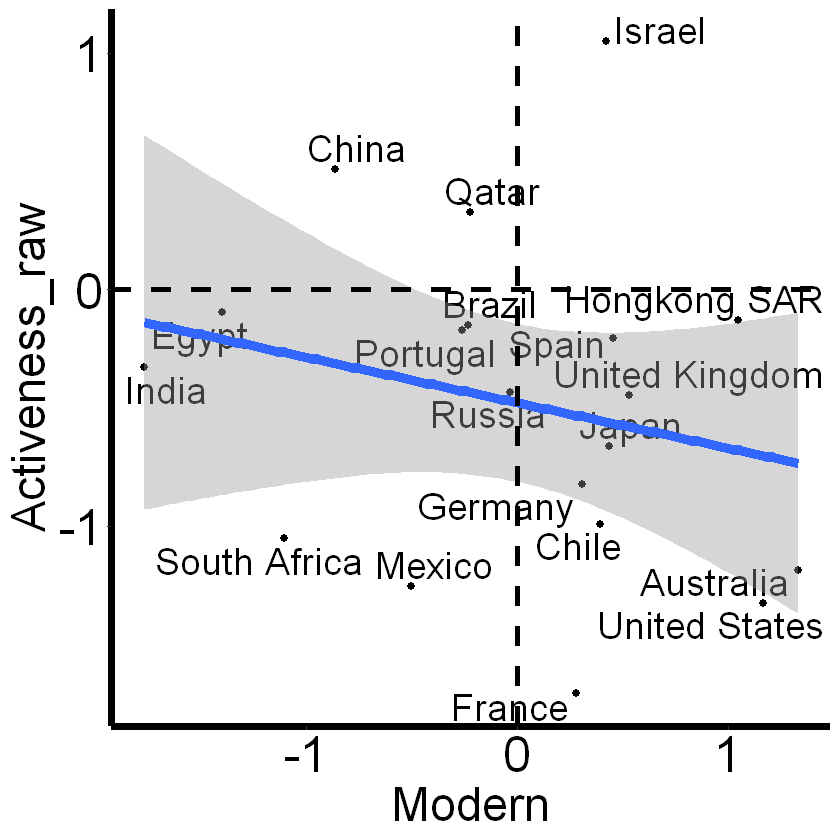

In [13]:
Plot_corr(data=Raw_modern,ylabel=Activeness_raw)

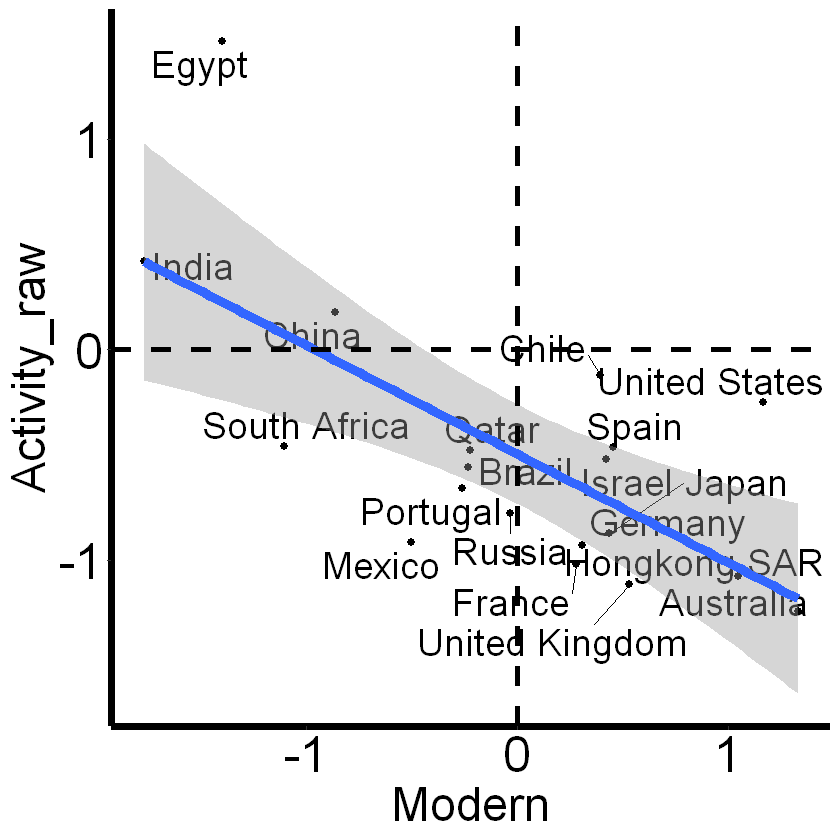

In [14]:
Plot_corr(data=Raw_modern,ylabel=Activity_raw)

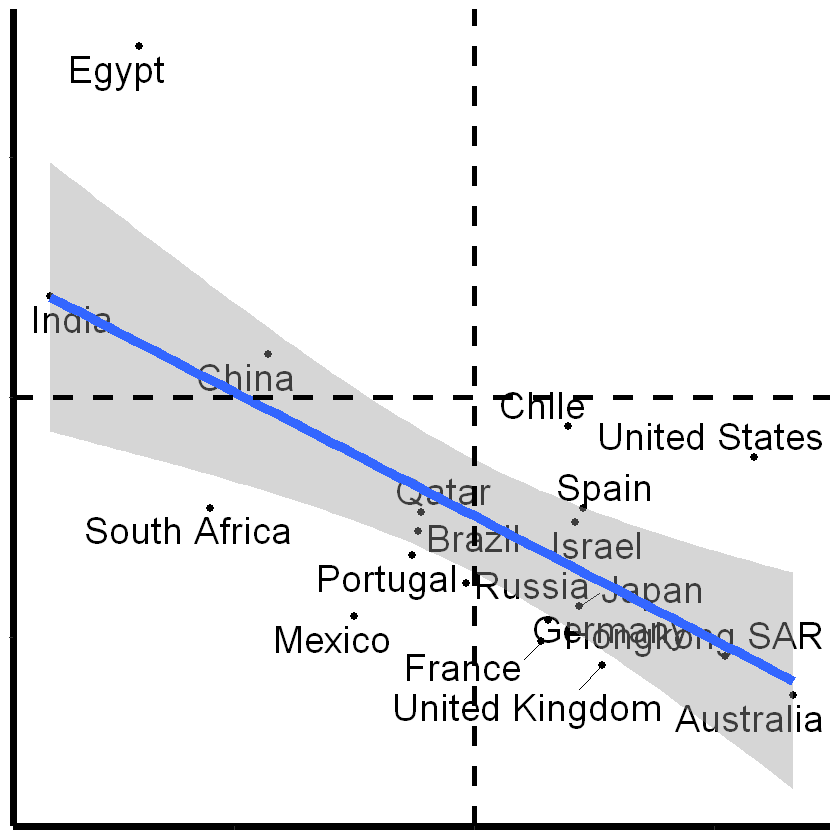

In [15]:
Plot_corr_nolabel(data=Raw_modern,ylabel=Activity_raw)

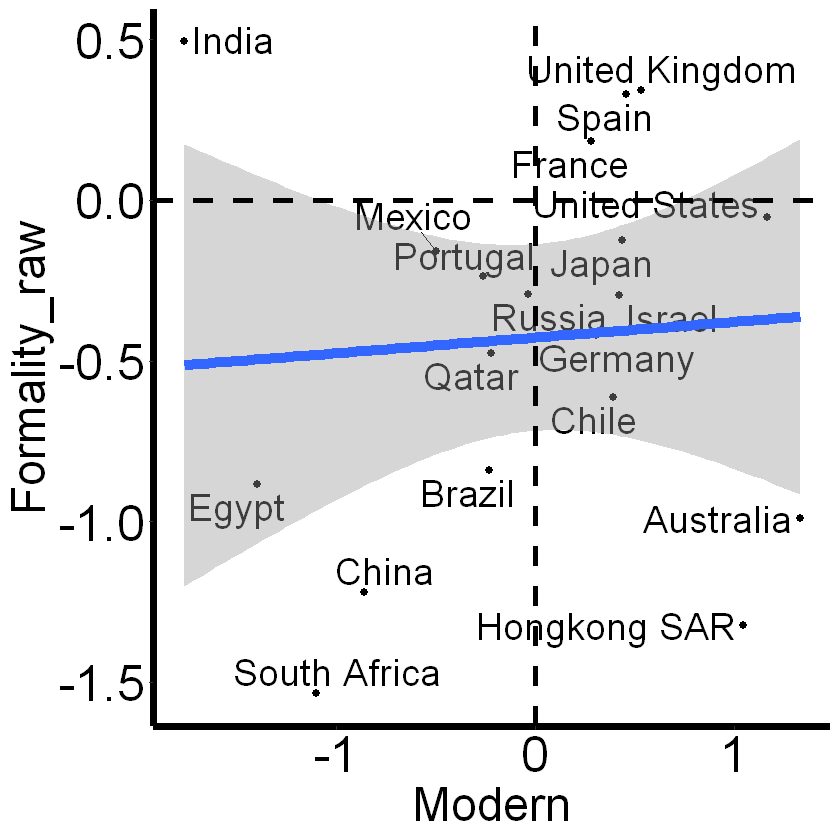

In [16]:
Plot_corr(data=Raw_modern,ylabel=Formality_raw)

# "Neighors" of Neighbor in FAVEE space

## Import data

In [13]:
file_path = '../../../DataCleanPCA/output_data/cleaning_results/'

raw_data_list = list()
for (region in dir(file_path)[-which(dir(file_path)=="ReadMe.txt")]){
    file = paste(file_path,region,sep='')
    file = paste(paste(file,'/',sep=''),region,sep='')
    file = paste(file,'_dim_rel_scaled.csv',sep='')
    raw_df = read.csv(file,row.names=1)
    
    region = gsub('HK','HK(region)',region) 
    region = gsub('South_africa','South Africa',region)
    raw_data_list[[region]] = raw_df}

mapping = read.csv('../../../../Study2/input_data/Rel_labels/labels_different_versions.csv',
                  row.names=1)
rdm_list = list()
for (region in regions){
    region_raw_data = raw_data_list[[region]]
    rdm = data.frame(as.matrix(dist(region_raw_data,
                             method = 'euclidean')))
    relationships = rownames(rdm)
    relationships_simple = mgsub(relationships,mapping$'one',mapping$'common')
    
    rownames(rdm) = relationships_simple
    colnames(rdm) = relationships_simple
    rdm_list[[region]] = rdm}

In [14]:
scores_var=read.csv('../../../DataCleanPCA/input_data/Nations/Total/pca_results/Total_scores_var_5c_33d.csv',
                     row.names=1)
colnames(scores_var) = c('Activeness','Exchange','Formality','Equality','Valence')
scores_var['Activeness'] = -scores_var['Activeness']
scores_var['Formality'] = -scores_var['Formality']
scores_var['Valence'] = -scores_var['Valence']
rownames(scores_var) = mgsub(rownames(scores_var),mapping$'one',mapping$'common')

## Find neighbors of Neighbor

In [15]:
# pick up the most similar relations to the "Neighbors"
neighbors_near_rdm = list()
for (region in regions){
    rdm = rdm_list[[region]]
    near_rel = rownames(rdm %>% arrange(Neighbors) 
                        %>% select('Neighbors') %>% head(16))
    near_rdm = rdm[near_rel,near_rel]
    neighbors_near_rdm[[region]] = near_rdm}

In [21]:
rel_FAVEE = data.frame(matrix(ncol=5,nrow=19))
colnames(rel_FAVEE) = colnames(scores_var)
rownames(rel_FAVEE) = regions

for (region in regions){
    region_rdm = neighbors_near_rdm[[region]]
    region_neighbors = rownames(region_rdm)
    region_neighbors = region_neighbors[-which(region_neighbors=='Neighbors')]
    region_FAVEE = scores_var[region_neighbors,]
    rel_FAVEE[region,] = apply(region_FAVEE,2,mean)
}
#rel_FAVEE %>% arrange(-Formality)
#rel_FAVEE %>% arrange(-Activeness)

## Correlation

In [22]:
Formality = rel_FAVEE['Formality']
Activeness = rel_FAVEE['Activeness']
Valence = rel_FAVEE['Valence']
Exchange = rel_FAVEE['Exchange']
Equality = rel_FAVEE['Equality']
Dimensional_modern = cbind(Formality,Activeness,Valence,Exchange,Equality,modern_level)

cor(Dimensional_modern,method='spearman')

,Formality,Activeness,Valence,Exchange,Equality,avg
Formality,1.0000000,-0.28596491,-0.19473684,0.46315789,-0.37894737,0.48596491
Activeness,-0.2859649,1.00000000,-0.44035088,0.08421053,0.28070175,-0.34561404
Valence,-0.1947368,-0.44035088,1.00000000,-0.27543860,-0.28596491,0.03333333
Exchange,0.4631579,0.08421053,-0.27543860,1.00000000,-0.16491228,-0.08771930
Equality,-0.3789474,0.28070175,-0.28596491,-0.16491228,1.00000000,-0.02631579
avg,0.4859649,-0.34561404,0.03333333,-0.08771930,-0.02631579,1.00000000


In [23]:
cor.test(x=Dimensional_modern$'avg',y=Dimensional_modern$'Formality',method='spearman')
cor.test(x=Dimensional_modern$'avg',y=Dimensional_modern$'Activeness',method='spearman')


	Spearman's rank correlation rho

data:  Dimensional_modern$avg and Dimensional_modern$Formality
S = 586, p-value = 0.0366
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4859649 



	Spearman's rank correlation rho

data:  Dimensional_modern$avg and Dimensional_modern$Activeness
S = 1534, p-value = 0.1475
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
-0.345614 


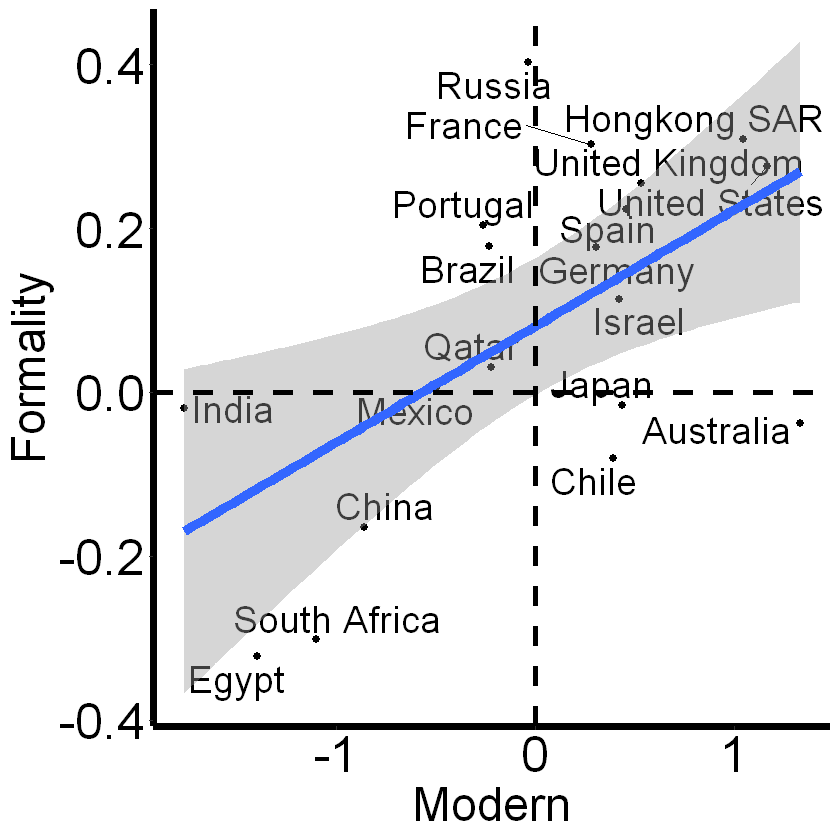

In [24]:
Plot_corr(data=Dimensional_modern,ylabel=Formality)

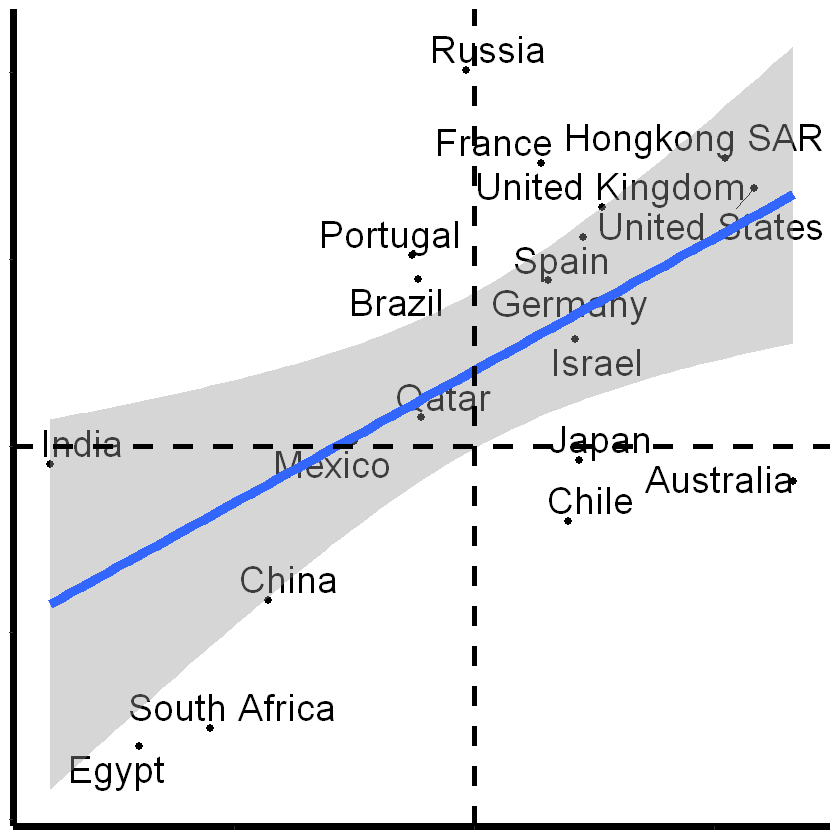

In [25]:
Plot_corr_nolabel(data=Dimensional_modern,ylabel=Formality)

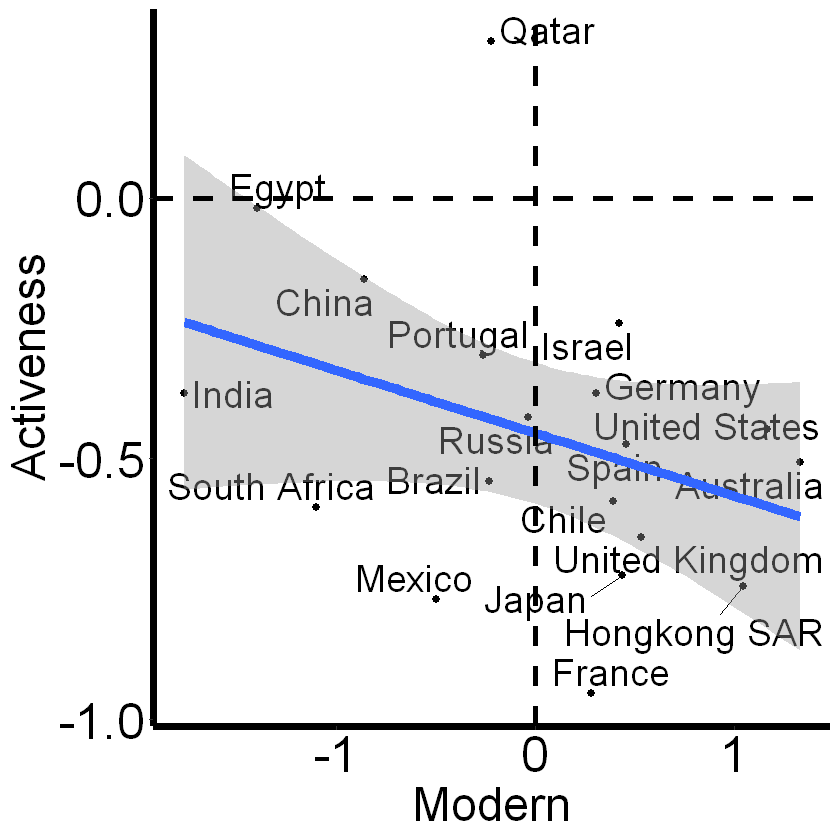

In [26]:
Plot_corr(data=Dimensional_modern,ylabel=Activeness)

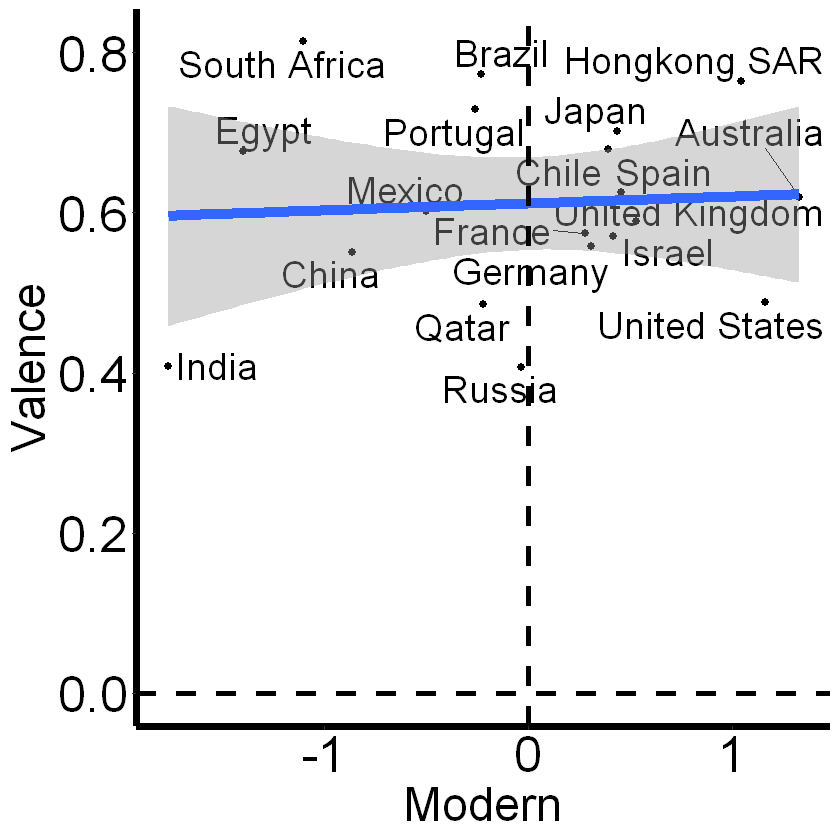

In [27]:
Plot_corr(data=Dimensional_modern,ylabel=Valence)

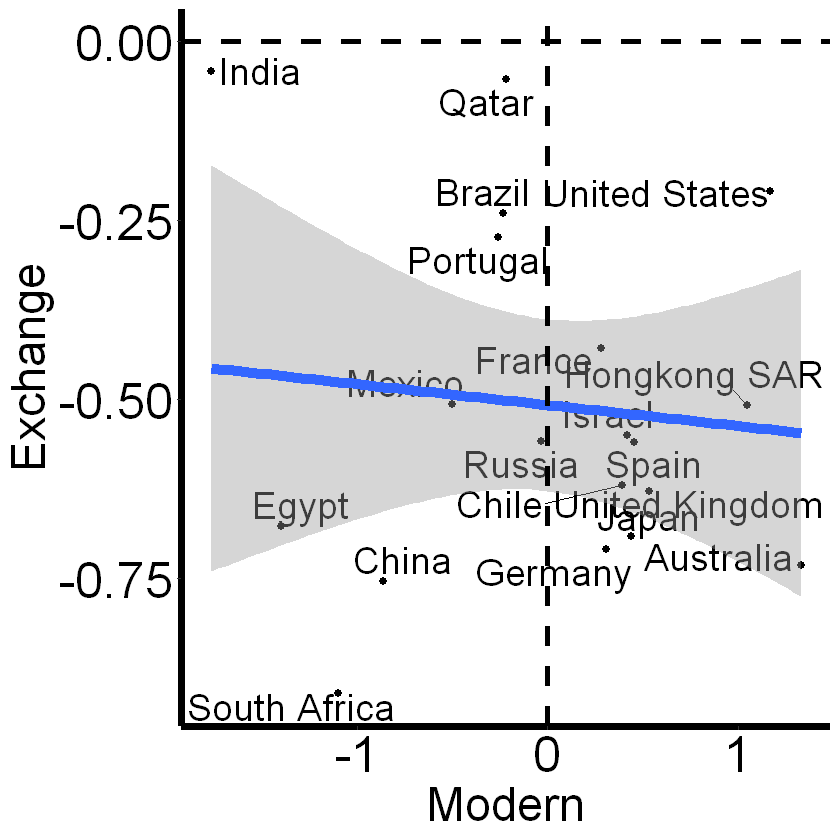

In [28]:
Plot_corr(data=Dimensional_modern,ylabel=Exchange)

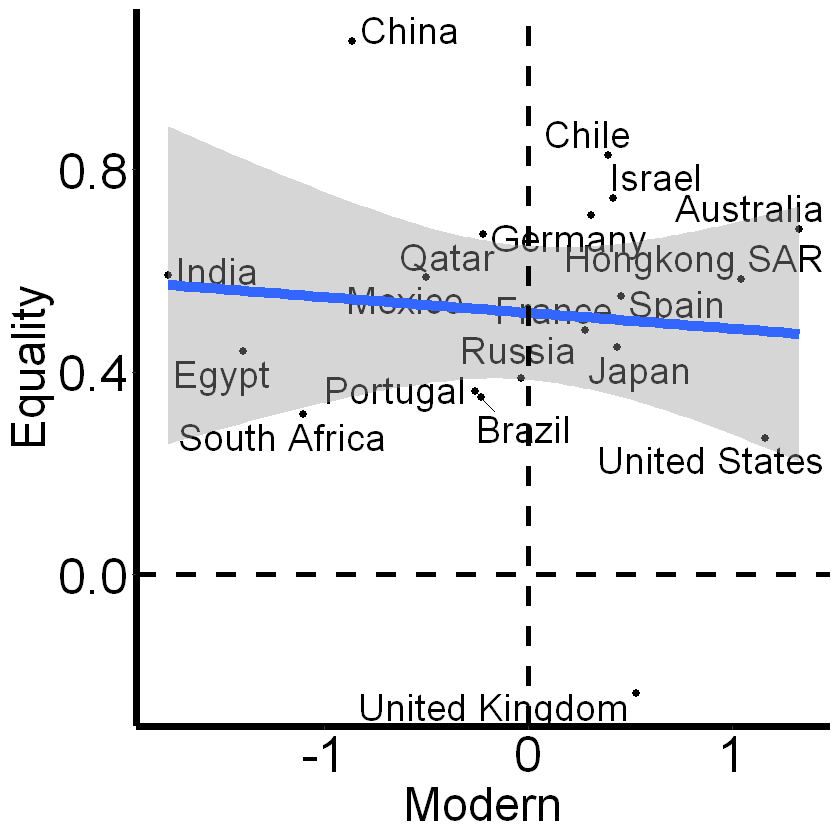

In [29]:
Plot_corr(data=Dimensional_modern,ylabel=Equality)